In [1]:
from pathlib import Path
import itertools
import numpy as np
import matplotlib.pylab as plt
# %matplotlib nbagg
# %matplotlib inline
import h5py
import json

# Loading files

In [2]:
DIR = "C:/LINHC/Software/Python/L737/scribble/xin/trelleborg"

filename_1 = Path("C:/LINHC/VersucheDBs/Trelleborg/2021-01-27-V24/2_Phase_A-D/20210127_Phase_A-D_LEM1.h5")
# filename_2 = Path("C:/LINHC/VersucheDBs/Trelleborg/2021-01-27-V24/2_Phase_A-D/20210127_Phase_A-D_LEM2.h5")

h51 = h5py.File(filename_1, "r")
# h52 = h5py.File(filename_2, "r")

print("ATTR:")
print(h51.attrs.keys())

print("Keys:")
print(h51.keys())

# frequency index
fidx = 20

ATTR:
<KeysViewHDF5 ['name_lookup', 'name_rev_lookup']>
Keys:
<KeysViewHDF5 ['S11_LEM1', 'S21_P1_LEM1', 'S21_P2_LEM1', 'S22_LEM1', 'hub1', 'hub2', 'ip1k1', 'ip1k2', 'ip2k1', 'ip2k2', 'k1at', 'k1f', 'k1p', 'k1t', 'k2at', 'k2f', 'k2p', 'k2t', 'phi', 'pos1', 'pos2', 'shub1', 'shub2', 'sk1at', 'sk1f', 'sk1p', 'sk1t', 'sk2at', 'sk2f', 'sk2p', 'sk2t', 'spd1', 'spd2', 'sphi', 'spos1', 'spos2', 'sspd1', 'sspd2', 'stdf', 't', 'tdf']>


In [3]:
# json.loads(h51.attrs["name_lookup"])

# Find the low speed areas

all low speed areas (low)

In [5]:
low = np.where(h51['spd1'][:]>-50)[0]
pos_low = h51['pos1'][low]

all low speed areas as seperate arrays

In [6]:
low_sep = np.where(np.diff(low)>10000)[0]
pos_low_sep = np.split(pos_low,low_sep+1)

cut out some points to make sure all points in low speed 
(if not some points in high speed area will showed up in s21, especially in later timestamps)

In [7]:
Ls = np.append(low[low_sep],low[-1])
print("timestamps of Ls:")
print (Ls)

Fs = np.append(low[0],low[low_sep+1])
print("timestamps of Fs:")
print (Fs)

print("Durations of lsa:\n",Ls-Fs)

timestamps of Ls:
[ 14443  35899  57359  78815 100274 121732 143192 164649 186106 207561
 229019 250475 271931 293390 314847 336304 357760 379214 400670 422129
 443587 465047 486506 507966 529422 550879 572338 593794 615254 636714
 658168 679621 701081 722537 743992 765451 786909 808367 829825 851284
 872738 894197 915655 937110 958570 980026]
timestamps of Fs:
[ 11670  33126  54583  76043  97498 118957 140416 161876 183333 204790
 226245 247702 269159 290615 312073 333530 354987 376444 397897 419354
 440813 462271 483731 505189 526650 548106 569563 591022 612478 633938
 655398 676852 698305 719764 741221 762676 784135 805593 827050 848509
 869967 891422 912880 934339 955794 977254]
Durations of lsa:
 [2773 2773 2776 2772 2776 2775 2776 2773 2773 2771 2774 2773 2772 2775
 2774 2774 2773 2770 2773 2775 2774 2776 2775 2777 2772 2773 2775 2772
 2776 2776 2770 2769 2776 2773 2771 2775 2774 2774 2775 2775 2771 2775
 2775 2771 2776 2772]


find the max values of positions in each low speed interval

In [8]:
# create a list of arrays max_sep, each array contains peak values of the corresponding low speed area.
max_sep = [] # (46,4)
for k in range(len(pos_low_sep)):
    # temporary sequency ts
    ts = pos_low_sep[k] 

    # find top 30 highest values
    max_20 = np.argsort(ts)[-30:][::-1]

    # filter the max value for each period
    temp =[max_20[0]]
    for i in max_20:
        if all([abs(j-i)>50 for j in temp]):        
            temp.append(i)
    max_sep.append(np.sort(temp))
    
# There should be 4 max values in each interval
assert all([len(max_sep[i])==4 for i in range(len(max_sep))]) 

In [9]:
# # choose intervals with safe points (2000 points after the first peak value, 
# 2000 is to make sure no points in hsa are included, peak value is to make sure the same starting point for each interval)
pos_low_sep_safe=[]
s21_low_sep_safe=[]
for i,F in enumerate(Fs):   
    pos_low_sep_safe.append(h51['pos1'][F+max_sep[i][0] : F+max_sep[i][0]+2000])
    s21_low_sep_safe.append(h51['S21_P1_LEM1'][F+max_sep[i][0] : F+max_sep[i][0]+2000, fidx])

In [10]:
pos_low_sep_safe[0]

array([124.78      , 124.77533372, 124.76652972, ..., 117.72868128,
       117.35626967, 116.96403987])

## Grid search

In [11]:
# import pickle
# saved_dic = pickle.load( open( "dtw.pickle", "rb" ) )

In [12]:
s1 = abs(s21_low_sep_safe[0])
s2 = abs(s21_low_sep_safe[1])
shift_opt =0
dist_opt = np.linalg.norm(s1-s2)

for shift in range(1,20):
    dist = np.linalg.norm(s1[shift:]-s2[:-shift])
    dist_inv = np.linalg.norm(s1[:-shift]-s2[shift:])
    if dist<dist_opt:
        shift_opt = shift
        dist_opt = dist
    if dist_inv < dist_opt:
        shift_opt = -shift
        dist_opt = dist_inv
print(shift_opt)

6


In [13]:
# s1 = abs(np.concatenate(s21_low_sep_int[1]))
# s2 = abs(np.concatenate(s21_low_sep_int[2]))
s1 = abs(s21_low_sep_safe[1])
s2 = abs(s21_low_sep_safe[2])
shift_opt =0
dist_opt = np.linalg.norm(s1-s2)

for shift in range(1,20):
    dist = np.linalg.norm(s1[shift:]-s2[:-shift])
    dist_inv = np.linalg.norm(s1[:-shift]-s2[shift:])
    if dist<dist_opt:
        shift_opt = shift
        dist_opt = dist
    if dist_inv < dist_opt:
        shift_opt = -shift
        dist_opt = dist_inv
print(shift_opt)

7


In [14]:
SHIFT1_OPT = 31
SHIFT3_OPT = 45

By naked eyes, SHIFT3_OPT = 45
by grid search, shift_opt for the 3rd lsa is 31+6+7 = 44

In [15]:
len(pos_low_sep_safe)

46

In [16]:
# grid search for all lsas with frequency 20

shift_opts_int = [SHIFT1_OPT]
for i in range(len(s21_low_sep_safe)-1):
    s1 = abs(s21_low_sep_safe[i])
    s2 = abs(s21_low_sep_safe[i+1])
    shift_opt = 0
    dist_opt = np.linalg.norm(s1-s2)
    
    for shift in range(1,20):
        dist = np.linalg.norm(s1[shift:]-s2[:-shift])
        dist_inv = np.linalg.norm(s1[:-shift]-s2[shift:])
        if dist<dist_opt:
            shift_opt = shift
            dist_opt = dist
        if dist_inv < dist_opt:
            shift_opt = -shift
            dist_opt = dist_inv
    shift_opts_int.append(shift_opt)
shift_opts = np.cumsum(shift_opts_int)
shift_opts

array([ 31,  37,  44,  51,  58,  64,  72,  79,  86,  93, 100, 106, 114,
       120, 128, 135, 143, 149, 157, 164, 171, 178, 185, 192, 199, 205,
       212, 219, 225, 232, 239, 247, 253, 260, 268, 275, 282, 288, 295,
       302, 309, 316, 322, 329, 337, 344], dtype=int32)

In [17]:
s1 = abs(s21_low_sep_safe[0])
s2 = abs(s21_low_sep_safe[1])
shift_opt =0
dist_opt = np.linalg.norm(s1-s2)

for shift in range(1,20):
    dist = np.linalg.norm(s1[shift:]-s2[:-shift])
    dist_inv = np.linalg.norm(s1[:-shift]-s2[shift:])
    if dist<dist_opt:
        shift_opt = shift
        dist_opt = dist
    if dist_inv < dist_opt:
        shift_opt = -shift
        dist_opt = dist_inv
print(shift_opt)

6


## Plots

In [18]:
# changed a bit because it's better to shift s21
def plot_p_s(pos,s21,s21_shift):
    
    """
    plot the scattering parameters and shifted scattering parameters with respect to postions 
    """
    
    fig = plt.figure(figsize=(12,8))
    fig.suptitle('scattering parameters with respect to positions', fontsize=16)
    # original
    ax1 = plt.subplot(2,1,1)
    ax1.plot(pos,s21,'.',label='s21')
    ax1.title.set_text('original')
    ax1.legend()
    
    # plots after shift
    ax2 = plt.subplot(2,1,2)
    ax2.plot(pos,s21_shift,'.',label='s21_shift')
    ax2.title.set_text('after shift')
    ax2.legend()

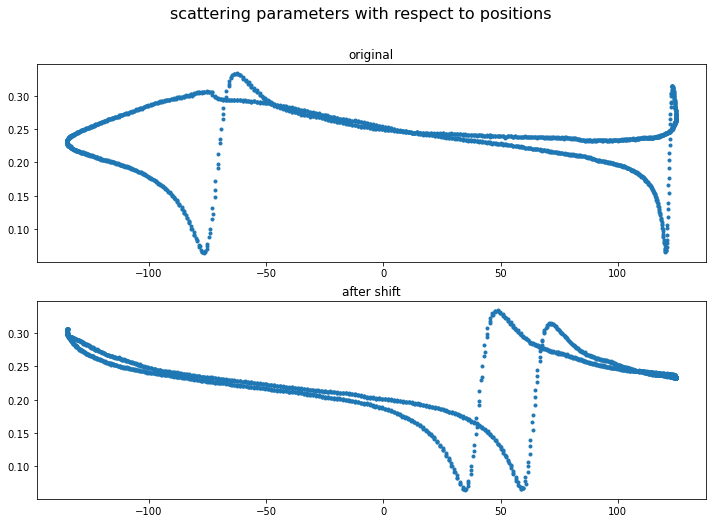

In [123]:
# DTW_LVL on 10th lsa

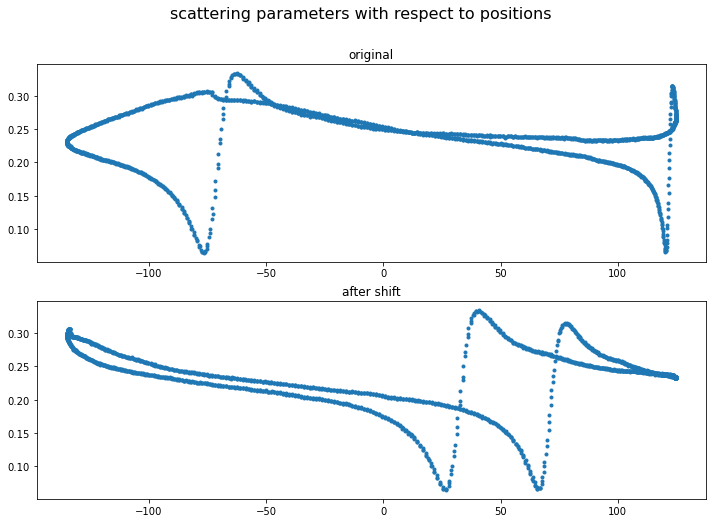

In [124]:
# DTW_PVP on 10th lsa

In [19]:
# grid search on 10th lsa
F = Fs[10]+max_sep[10][0]
L = Fs[10]+max_sep[10][-1]
pos = h51['pos1'][F:L]
s21 = abs(h51['S21_P1_LEM1'][F:L,fidx])
s21_shift = abs(h51['S21_P1_LEM1'][F- shift_opts[10]:L- shift_opts[10],fidx])

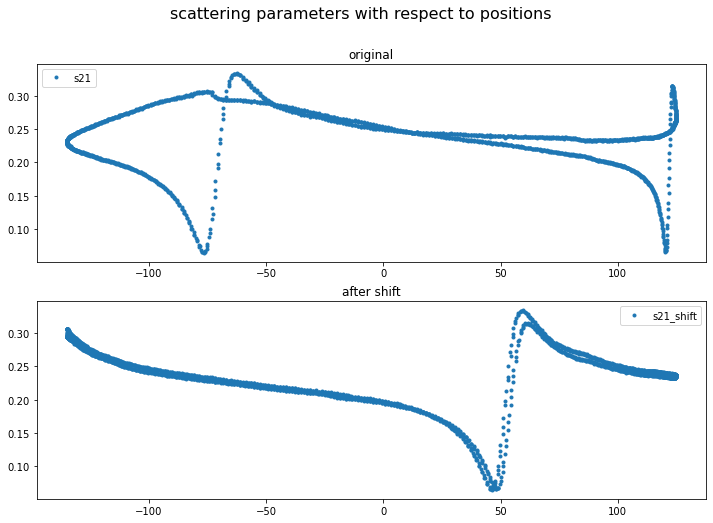

In [20]:
%matplotlib inline
plot_p_s(pos,s21,s21_shift)

In [21]:
# grid search on the 45th (second to last) lsa
F = Fs[45]+max_sep[45][0]
L = Fs[45]+max_sep[45][-1]
pos = h51['pos1'][F:L]
s21 = abs(h51['S21_P1_LEM1'][F:L,fidx])
s21_shift = abs(h51['S21_P1_LEM1'][F- shift_opts[45]:L- shift_opts[45],fidx])

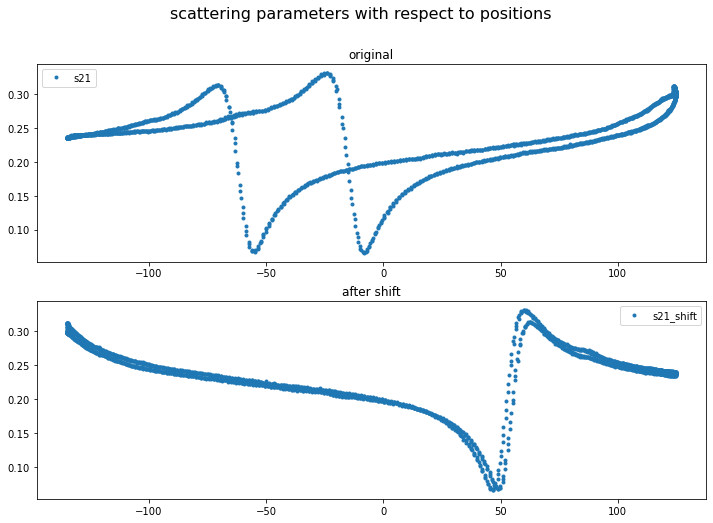

In [22]:
%matplotlib inline
plot_p_s(pos,s21,s21_shift)

## Grid Search for all frequencies

In [22]:
# # changed a bit because it's better to shift s21
# def plot_p_s(pos,s21,s21_shift):
    
#     """
#     plot the scattering parameters with respect to postions at LAST
#     """
    
#     fig = plt.figure(figsize=(12,8))
#     fig.suptitle('scattering parameters with respect to positions', fontsize=16)
#     # original
#     ax1 = plt.subplot(2,1,1)
#     ax1.plot(pos,s21,'.',label='s21')
#     ax1.title.set_text('original')
#     ax1.legend()
    
#     # plots after shift
#     ax2 = plt.subplot(2,1,2)
#     ax2.plot(pos,s21_shift,'.',label='s21_shift')
#     ax2.title.set_text('after shift')
#     ax2.legend()

In [23]:
# # choose intervals with safe points (2000 points after the first peak value, 
# 2000 is to make sure no points in hsa are included, peak value is to make sure the same starting point for each interval)
pos_low_sep_safe=[]
s21_low_sep_safe=[]
for i,F in enumerate(Fs):   
    pos_low_sep_safe.append(h51['pos1'][F+max_sep[i][0] : F+max_sep[i][0]+2000])
    s21_low_sep_safe.append((h51['S21_P1_LEM1'][F+max_sep[i][0] : F+max_sep[i][0]+2000, :]).transpose())

In [24]:
# 46 lsas,  121 frequencies, 2000 points for each lsa,
s21_low_sep_safe[0][20].shape

(2000,)

In [25]:
shift_opts_freqs=[]
for freq in range (70):
    shift_opts_int=[31]
    for i in range(len(s21_low_sep_safe)-1):
        s1 = abs(s21_low_sep_safe[i][freq])
        s2 = abs(s21_low_sep_safe[i+1][freq])
        shift_opt = 0
        dist_opt = np.linalg.norm(s1-s2)
        for shift in range(1,20):
            dist = np.linalg.norm(s1[shift:]-s2[:-shift])
            dist_inv = np.linalg.norm(s1[:-shift]-s2[shift:])
            if dist<dist_opt:
                shift_opt = shift
                dist_opt = dist
            if dist_inv < dist_opt:
                shift_opt = -shift
                dist_opt = dist_inv
        shift_opts_int.append(shift_opt)
    shift_opts = np.cumsum(shift_opts_int)
    shift_opts_freqs.append(shift_opts)
shift_opts_freqs[20]

array([ 31,  37,  44,  51,  58,  64,  72,  79,  86,  93, 100, 106, 114,
       120, 128, 135, 143, 149, 157, 164, 171, 178, 185, 192, 199, 205,
       212, 219, 225, 232, 239, 247, 253, 260, 268, 275, 282, 288, 295,
       302, 309, 316, 322, 329, 337, 344], dtype=int32)

In [26]:
shift_opts_freqs2=[]
for freq in range (70,121):
    shift_opts_int=[33]
    for i in range(len(s21_low_sep_safe)-1):
        s1 = abs(s21_low_sep_safe[i][freq])
        s2 = abs(s21_low_sep_safe[i+1][freq])
        shift_opt = 0
        dist_opt = np.linalg.norm(s1-s2)

        for shift in range(1,20):
            dist = np.linalg.norm(s1[shift:]-s2[:-shift])
            dist_inv = np.linalg.norm(s1[:-shift]-s2[shift:])
            if dist<dist_opt:
                shift_opt = shift
                dist_opt = dist
            if dist_inv < dist_opt:
                shift_opt = -shift
                dist_opt = dist_inv
        shift_opts_int.append(shift_opt)
    shift_opts = np.cumsum(shift_opts_int)
    shift_opts_freqs2.append(shift_opts)
shift_opts_freqs += shift_opts_freqs2 

In [27]:
# shift_opts_freqs, 121 frequencies * 46 lsas, 
len(shift_opts_freqs)

121

In [175]:
import pickle

filename = "20210127_Phase_A-D_LEM1.pkl" # first dataset

pickle.dump(np.array(shift_opts_freqs), open( DIR + "/data/shift_opts_freqs/" + filename + ".pkl", "wb" ))

## Plots for all frequencies

In [16]:
# # changed a bit because it's better to shift s21
# def plot_p_s(pos,s21,s21_shift):
    
#     """
#     plot the scattering parameters and shifted scattering parameters with respect to postions 
#     """
    
#     fig = plt.figure(figsize=(12,8))
#     fig.suptitle('scattering parameters with respect to positions', fontsize=16)
#     # original
#     ax1 = plt.subplot(2,1,1)
#     ax1.plot(pos,s21,'.',label='s21')
#     ax1.title.set_text('original')
#     ax1.legend()
    
#     # plots after shift
#     ax2 = plt.subplot(2,1,2)
#     ax2.plot(pos,s21_shift,'.',label='s21_shift')
#     ax2.title.set_text('after shift')
#     ax2.legend()

In [ ]:
# # used to choose the SHIFT_OPT for each frequency
# def plot_p_s_save(pos,s21,s21_shift):
    
#     """
#     plot the scattering parameters with respect to postions at LAST
#     """
    
#     fig = plt.figure(figsize=(12,8))
#     fig.suptitle('scattering parameters with respect to positions', fontsize=16)
#     # original
#     ax1 = plt.subplot(2,1,1)
#     ax1.plot(pos,s21,'.',label='s21')
#     ax1.title.set_text('original')
#     ax1.legend()
    
#     # plots after shift
#     ax2 = plt.subplot(2,1,2)
#     ax2.plot(pos,s21_shift,'.',label='s21_shift')
#     ax2.title.set_text('after shift')
#     ax2.legend()

# shifts = [30,31,32,33]

# for freq in range(0,121,10):
#     for shift in shifts:
#         F = Fs[0]+max_sep[0][0]
#         L = Fs[0]+max_sep[0][-1]
#         pos = h51['pos1'][F:L]
#         s21 = abs(h51['S21_P1_LEM1'][F:L,freq])
#         s21_shift = abs(h51['S21_P1_LEM1'][F- shift:L- shift,freq])
#         plot_p_s(pos,s21,s21_shift)
#         fname = DIR + '/pics/' + str(freq) + '_' + str(shift)
#         plt.savefig(fname,facecolor='w')

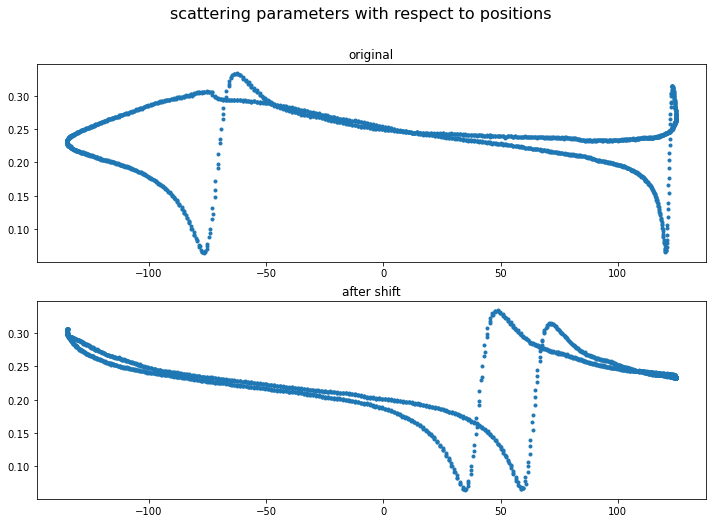

In [123]:
# DTW_LVL on 10th lsa

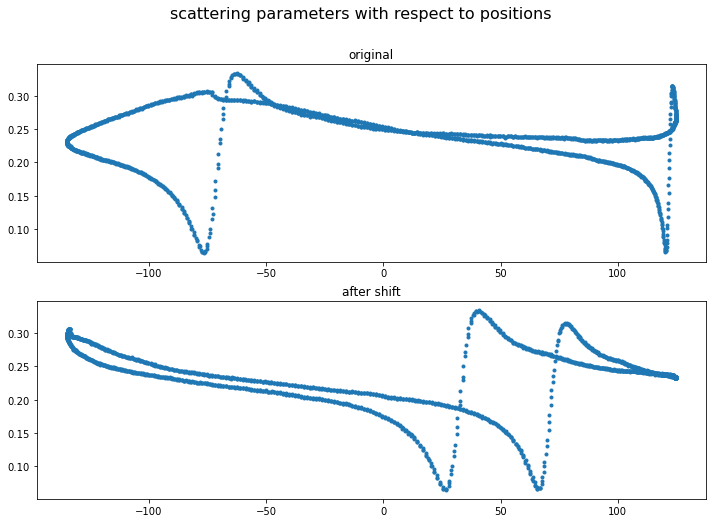

In [124]:
# DTW_PVP on 10th lsa

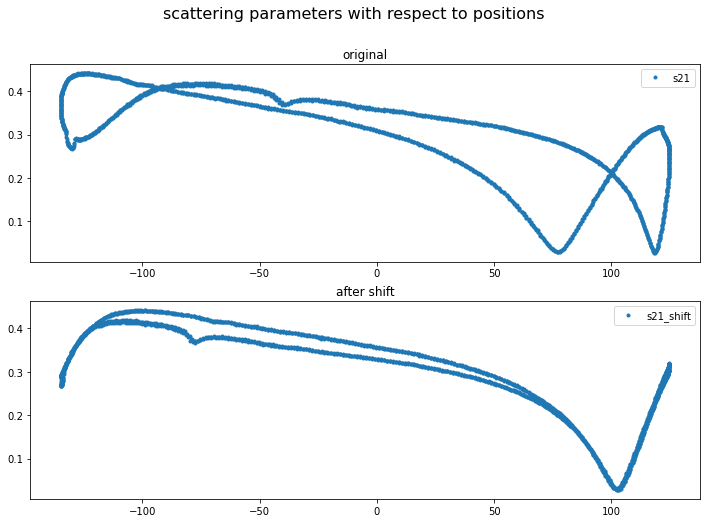

In [28]:
shift = 32
freq = 10
F = Fs[0]+max_sep[0][0]
L = Fs[0]+max_sep[0][-1]
pos = h51['pos1'][F:L]
s21 = abs(h51['S21_P1_LEM1'][F:L,freq])
s21_shift = abs(h51['S21_P1_LEM1'][F- shift:L- shift,freq])

plot_p_s(pos,s21,s21_shift)

In [32]:
# grid search on 10th lsa
F = Fs[10]+max_sep[10][0]
L = Fs[10]+max_sep[10][-1]
pos = h51['pos1'][F:L]
s21 = abs(h51['S21_P1_LEM1'][F:L,fidx])
s21_shift = abs(h51['S21_P1_LEM1'][F- shift_opts_freqs[fidx][10]:L- shift_opts_freqs[fidx][10],fidx])

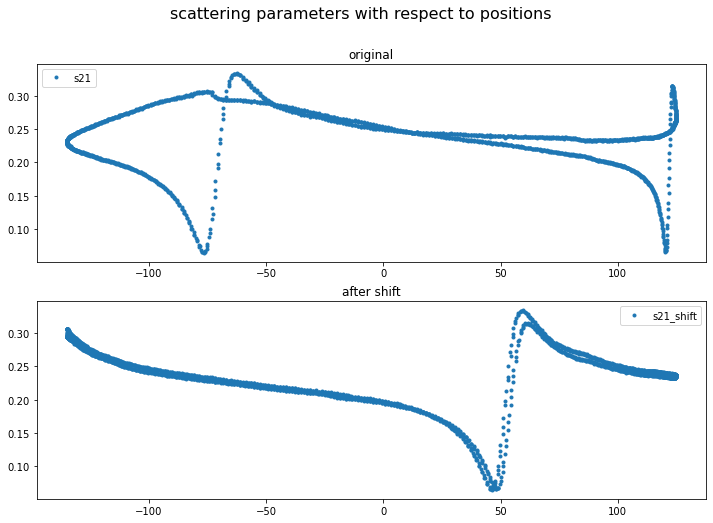

In [33]:
%matplotlib inline
plot_p_s(pos,s21,s21_shift)

In [34]:
# grid search on the 45th (second to last) lsa
F = Fs[45]+max_sep[45][0]
L = Fs[45]+max_sep[45][-1]
pos = h51['pos1'][F:L]
s21 = abs(h51['S21_P1_LEM1'][F:L,fidx])
s21_shift = abs(h51['S21_P1_LEM1'][F- shift_opts_freqs[fidx][45]:L- shift_opts_freqs[fidx][45],fidx])

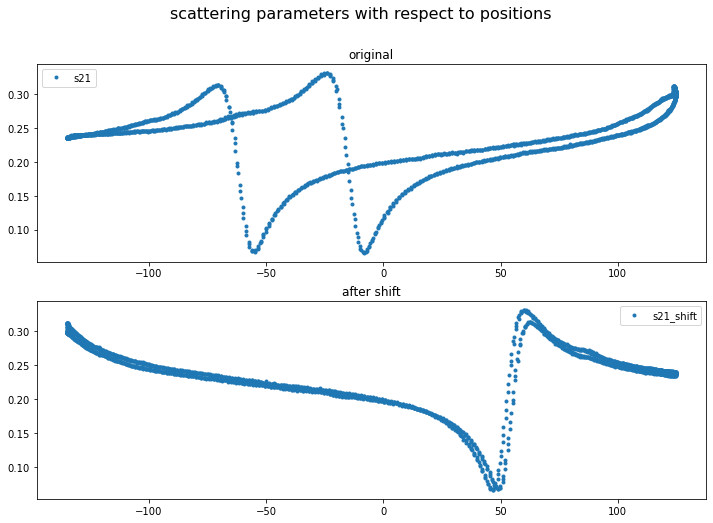

In [35]:
%matplotlib inline
plot_p_s(pos,s21,s21_shift)